In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numba as nb
import pandas_ta
import os
import datetime
import json
import seaborn as sns
from tabulate import tabulate
import sys
sys.path.append('../..')
import vectorbt as vbt
from vectorbtpro.portfolio.enums import SizeType
from src.utils import fu
from src.utils import plot_return_mdd
from src.strategy.BackTester import BackTester
from src.strategy.Analyzer import Analyzer
from src.strategy.MultiTester import MultiTester
from src.utils import plot_return_mdd,twinx_plot # as utils
from monday import get_data,Strategy
sns.set_style("darkgrid")

../..\vectorbtpro\accessors.py:188: UserWarning: registration of accessor <class 'vectorbtpro.accessors.Vbt_SRAccessor'> under name 'vbt' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  class Vbt_SRAccessor(DirNamesMixin, GenericSRAccessor):
../..\vectorbtpro\accessors.py:208: UserWarning: registration of accessor <class 'vectorbtpro.accessors.Vbt_DFAccessor'> under name 'vbt' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  class Vbt_DFAccessor(DirNamesMixin, GenericDFAccessor):


In [2]:
df_dict = {}
candidate = ['BTC']
# candidate = ['SOL','ETH']
for coin in candidate:
    df_dict[coin] = get_data(coin)

APY: 51.71 %
MDD: 16.66 %
MDD Duration 223 days 19:00:00
worst trade: -12.40 %
2022-02-27 00:00:00 ~ 2022-03-01 00:00:00
avg holding days: 1.44 days
--------------------------------------------
PF: 1.89
Sharpe Ratio: 1.76
Calmar Ratio: 2.57
Sortino Ratio: 2.66
Omega Ratio: 1.14
--------------------------------------------
Expectancy : 0.76 %
Total Time Exposure : 27.37 %
Total Trades: 136
Win Rate: 54.07 %
--------------------------------------------
PF * Win Rate: 1.019


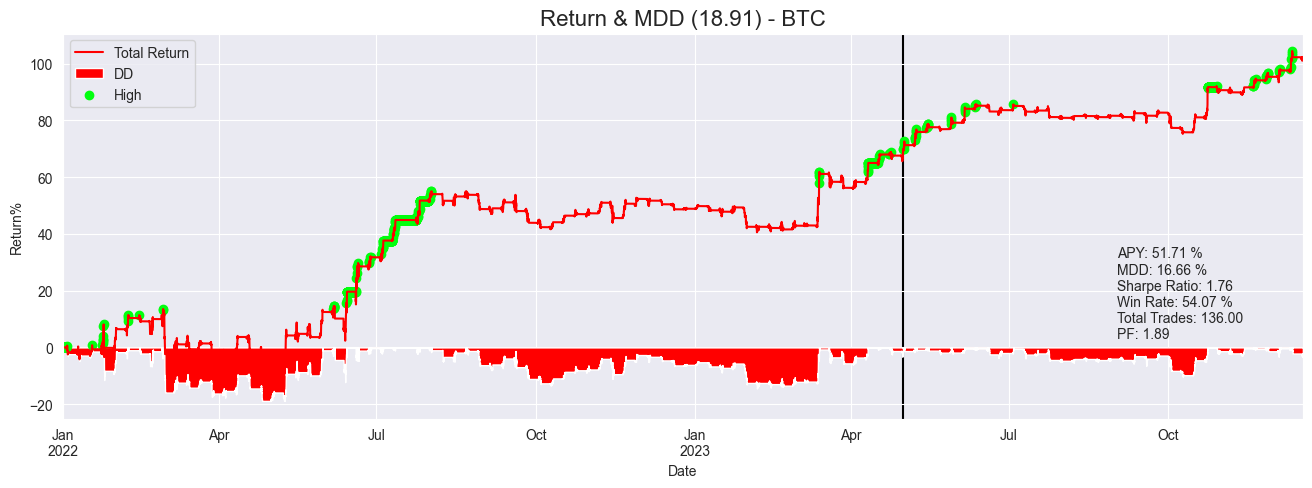

In [6]:
start = '2022-01-01'
sep = ''
end = ''
# new version
# 到禮拜五:{'vol_threshold': 0.05, 'ret_threshold': 0.3}
# 到禮拜一:{'vol_threshold': 0.01, 'ret_threshold': 0.1}
# old version
# 到禮拜五:{'vol_threshold': 0.3, 'ret_threshold': 0.15}
# 到禮拜一:{'vol_threshold': 0.003125, 'ret_threshold': 0.15}
side = 'both'
params = {'vol_threshold': 0.003125, 'ret_threshold': 0.15}
config = {'freq':'1h', 'lag':1, 'fee': 0.0003}
coin = 'BTC'
df = df_dict[coin]
strategy = Strategy(df=df.loc[start:], configs=config)
_pf = strategy.strategy(side = side,params=params)
trades = _pf.trades.records_readable
analyze = Analyzer(strategy)
value = analyze.show_pf_analysis(params, side, coin, axv_index=['2023-05-01'])

<Axes: >

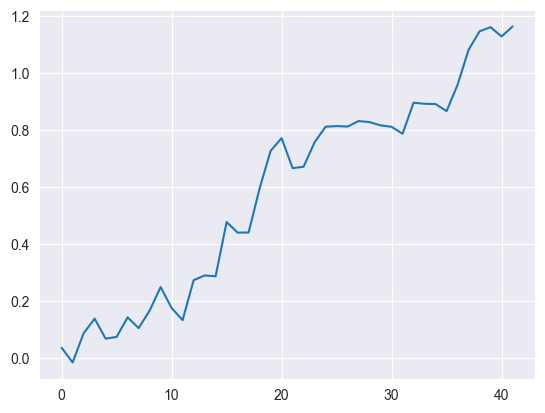

In [7]:
trades['Return'].cumsum().plot()

In [3]:
start= '2022-01-01'
end ='2023-12-01'

params={
   'vol_threshold': [0/48, 0.5/48, 0.05/48],
   'ret_threshold' : [0.1, 0.5, 0.05],
#    'sl' : [100, 101, 20],
#    'window': [12,96,4]
    }
    
config = {'freq':'1h','fee': 0.0003}
symbol_list = ['BTC']
sample_sets = [[start,end]]

multi_test = MultiTester(
    Strategy,
    get_data_func=get_data,
    params=params,
    config=config,
    df_dict=df_dict,
    symbol_list=symbol_list,
    start=start,
    end=end
    )

======================= BTC BOTH Optimize Test =======================
Optimization trails: 80


100%|██████████| 80/80 [02:34<00:00,  1.94s/it]


Optimization time: 154.86 sec
---------- BTC BOTH ----------
{'vol_threshold': 0.003125, 'ret_threshold': 0.15000000000000002}
APY: 49.81 %
MDD: 16.66 %
MDD Duration 223 days 19:00:00
worst trade: -12.40 %
2022-02-27 00:00:00 ~ 2022-03-01 00:00:00
avg holding days: 1.45 days
--------------------------------------------
PF: 1.84
Sharpe Ratio: 1.71
Calmar Ratio: 2.51
Sortino Ratio: 2.59
Omega Ratio: 1.13
--------------------------------------------
Expectancy : 0.72 %
Total Time Exposure : 27.29 %
Total Trades: 132
Win Rate: 53.79 %
--------------------------------------------
PF * Win Rate: 0.989


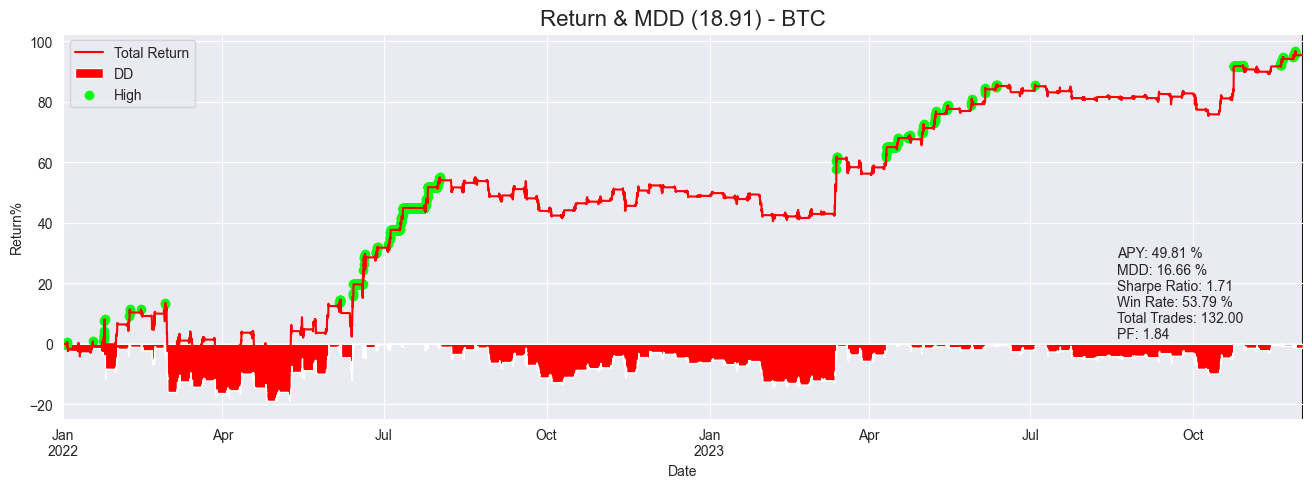

+------------+-----------+---------+----------+------------+---------+------------+
| datetime   |   收益率% |    毛利 |     毛損 |   獲利因子 |   勝率% |   交易次數 |
|------------+-----------+---------+----------+------------+---------+------------|
| 2022-03    |     -2.57 | 2447.41 | -2722.01 |       0.9  |   50    |         18 |
| 2022-06    |     35.25 | 5828.67 | -2376.83 |       2.45 |   52.63 |         19 |
| 2022-09    |     12.16 | 2784.12 | -1568.14 |       1.78 |   47.06 |         17 |
| 2022-12    |      4.96 | 1604.28 | -1108.15 |       1.45 |   56.25 |         16 |
| 2023-03    |      7.37 | 2378.64 | -1641.87 |       1.45 |   52.63 |         19 |
| 2023-06    |     27.39 | 3052.37 |  -313.31 |       9.74 |   80    |         15 |
| 2023-09    |     -0.88 |  605.55 |  -693.24 |       0.87 |   46.67 |         15 |
| 2023-12    |     12.61 | 2205.78 |  -944.48 |       2.34 |   46.15 |         13 |
+------------+-----------+---------+----------+------------+---------+------------+


In [4]:
all_params = multi_test.multi_params(symbol_list,sample_sets,direction='both')
trades, value_df = multi_test.multi_params_result(all_params)
# multi_test.save_version_result(all_params,value_df,trades,1)